In [ ]:
!pip install scikit-hep-testdata
!pip install uproot
!pip install "hist[plot,fit]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.8/382.8 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.8/886.8 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.8/638.8 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.4/444.4 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 48.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import skhep_testdata, uproot, hist

Median function for odd windows

In [ ]:
def moving_median_odd(data, window, endrule='median'):
    data = np.asarray(data, dtype=float)
    n = len(data)
    k2 = window // 2
    new_data = np.zeros(n, dtype=float)
    core = np.median(sliding_window_view(data, window), axis=1)
    new_data[k2:n - k2] = core

    if endrule == 'keep':
        new_data[:k2] = data[:k2]
        new_data[-k2:] = data[-k2:]

    elif endrule == 'median':
        for i in range(k2):
            new_data[i] = np.median(data[:2 * i + 1])
            new_data[-i - 1] = np.median(data[-(2 * i + 1):])
    else:
        raise ValueError(f"Unknown endrule: {endrule}")

    return new_data

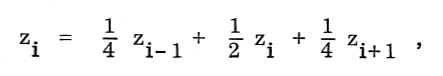
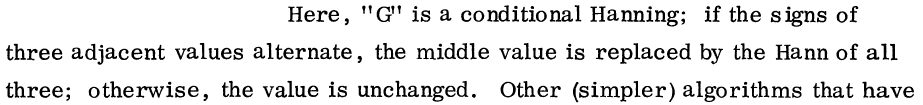

In [ ]:
def hanning(data, condition=False):
    data = np.asarray(data, dtype=float)

    windows = sliding_window_view(data, window_shape=3)
    smoothed_core = []

    for triplet in windows:
        a, b, c = triplet
        if condition:
            signs = np.sign([a, b, c])
            if np.all(signs != 0) and signs[0] == -signs[1] and signs[1] == -signs[2]:
                smoothed_core.append(0.25 * a + 0.5 * b + 0.25 * c)
            else:
                smoothed_core.append(b)
        else:
            smoothed_core.append(0.25 * a + 0.5 * b + 0.25 * c)

    smoothed_core = np.array(smoothed_core)

    result = np.empty_like(data)
    result[1 : -1] = smoothed_core
    result[0] = data[0]
    result[-1] = data[-1]

    return result

In [ ]:
def quadratic_interpolation(y):
    y_out = np.array(y, float).copy()
    for i in range(2, len(y)-2):
        if (y[i-1] == y[i] == y[i+1]) and ((y[i-2] < y[i] and y[i+2] < y[i]) or (y[i-2] > y[i] and y[i+2] > y[i])):
            left_dist = abs(y[i-2] - y[i])
            right_dist = abs(y[i+2] - y[i])
            if left_dist >= right_dist:
                x_fit = [i - 2, i - 1, i + 2]
                y_fit = [y[i-2], y[i-1], y[i+2]]
                indices_to_update = [i, i + 1]
            else:
                x_fit = [i - 2, i + 1, i + 2]
                y_fit = [y[i-2], y[i+1], y[i+2]]
                indices_to_update = [i - 1, i]
            coeffs = np.polyfit(x_fit, y_fit, 2)
            poly_func = np.poly1d(coeffs)
            for index in indices_to_update:
                y_out[index] = poly_func(index)
    return np.array(y_out, float)

In [ ]:
def twicing(original_data, smooth, algorithm, times=1):
    for _ in range(times):
        rough = original_data - smooth
        smooth = smooth + algorithm(rough)
    return smooth

In [ ]:
def even_median_four(data):
    new_data = np.zeros(len(data) + 1, dtype=float)
    core = np.median(sliding_window_view(data, 4), axis=1)
    new_data[0] = data[0]
    new_data[1] = (data[1] + data[0])/2
    new_data[2:-2] = core
    new_data[-2] = (data[-2] + data[-1])/2
    new_data[-1] = data[-1]
    return new_data

In [ ]:
def even_median_two(data):
    return np.median(sliding_window_view(data, 2), axis=1)

In [ ]:
def smh_4253H(data):
    return hanning(moving_median_odd(moving_median_odd(even_median_two(even_median_four(data)), 5), 3))

In [ ]:
def Smoothing(data, algorithm, endrule='median', twice=0):
    '''Main function. '''
    algorithms = {'4253H' : smh_4253H}
    if algorithm not in algorithms:
        fn = lambda d: d
        for action in algorithm[::-1]:
            if action.isdigit():
                fn = lambda d, p=fn, k=int(action), e=endrule: p(moving_median_odd(d, k, e))
            elif action.isalpha():
                if action == 'H':
                    fn = lambda d, p=fn: p(hanning(d))
                elif action == 'G':
                    fn = lambda d, p=fn: p(hanning(d, True))
                elif action == 'Q':
                    fn = lambda d, p=fn: p(quadratic_interpolation(d))
            else:
                raise ValueError(f"Invalid action '{action}'")
    else:
        fn = algorithms[algorithm]
    mod_data = fn(data)
    mod_data = twicing(data, mod_data, fn, times=twice)
    return mod_data

In [ ]:
mean = 0
std_dev = 1
size = 1000
data = np.random.normal(loc=mean, scale=std_dev, size=size)

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
def print_both(data, algorithm, bins, mean, std_dev):

    bins_number, s, e = bins
    x = np.linspace(s, e, 300)

    h = hist.Hist(hist.axis.Regular(bins_number, s, e))
    h.fill(data)
    h.plot()
    bin_counts = h.counts()

    mod_data = Smoothing(bin_counts, algorithm, twice=1)
    ratio = sum(mod_data) / sum(bin_counts)

    plt.plot(x, norm.pdf(x, mean, std_dev) * len(data) * (e - s) / bins_number,
                color='red', linestyle='--', label='Normal Dist')
    h2 = hist.Hist(hist.axis.Regular(bins_number, s, e))
    h2[...] = mod_data
    h2.plot(color='orange', linestyle='solid', label='Smoothing')
    plt.legend()
    textstr = f'Ratio: {ratio:.4f}\nPlaceholder: 22'
    plt.text(0.95, 0.95, textstr,
                fontsize=10, verticalalignment='top', horizontalalignment='left',
                bbox=dict(facecolor='white', alpha=0.6))

    plt.tight_layout()
    plt.show()

In [ ]:
bin = (30, -20, 20)
mean = 0
std_dev = 5
size = 10000
data = np.random.normal(loc=mean, scale=std_dev, size=size)

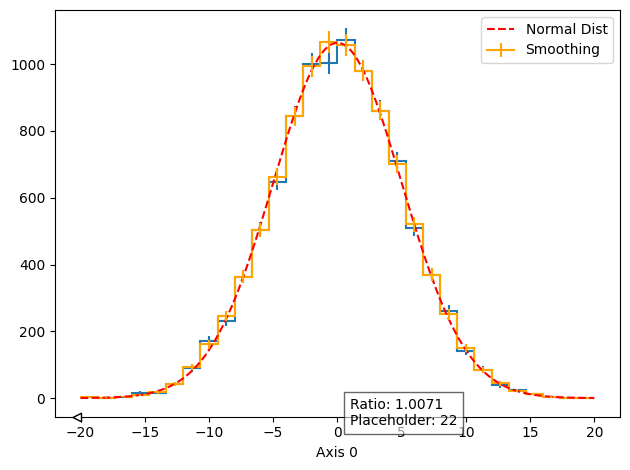

In [ ]:
print_both(data, '353QH', bin, mean, std_dev)

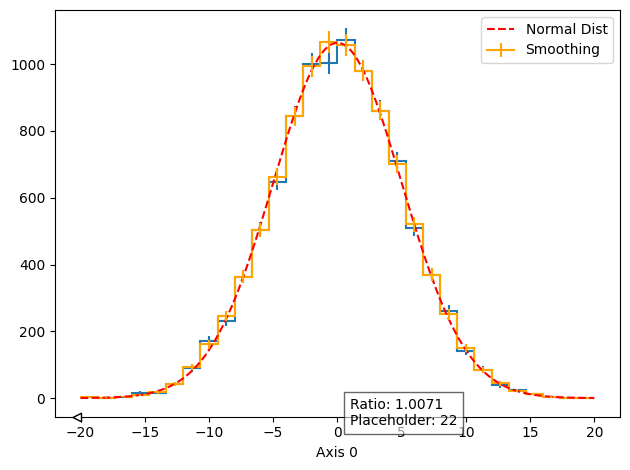

In [ ]:
print_both(data, '3G53QH', bin, mean, std_dev)

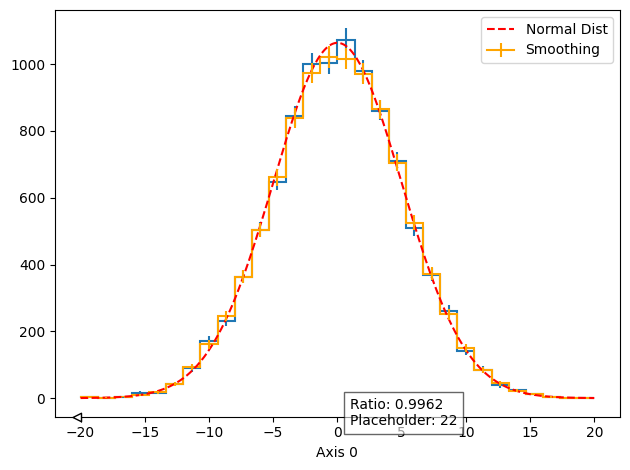

In [ ]:
print_both(data, '53H', bin, mean, std_dev)

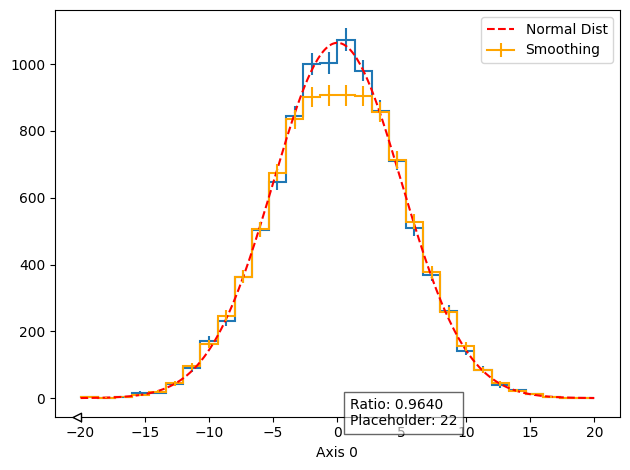

In [ ]:
print_both(data, '95H', bin, mean, std_dev)

/usr/local/lib/python3.11/dist-packages/mplhep/utils.py:649: RuntimeWarning: invalid value encountered in sqrt
  return values - np.sqrt(variances), values + np.sqrt(variances)


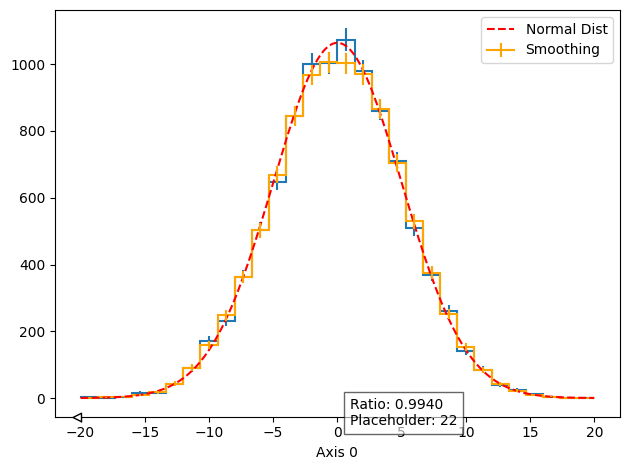

In [ ]:
print_both(data, '4253H', bin, mean, std_dev)

In [ ]:
from scipy.stats import ks_2samp
from scipy.stats import chi2

In [ ]:
def reduced_chi2(data1, data2, variance):
    mask = variance > 0
    chi_2 = np.sum(((data1[mask] - data2[mask]) ** 2) / (variance[mask]))
    n_dof = np.count_nonzero(mask) - 1
    #reduced_chi2 = chi2 / ndf
    reduced_chi2 = chi2.sf(chi_2, n_dof)
    return reduced_chi2

In [ ]:
import matplotlib.pyplot as plt
from hist import Hist
from hist.axis import Regular, StrCategory
from scipy.stats import ks_2samp
import numpy as np

In [ ]:
def print_mult_dif(data, algorithms, bins):
    if isinstance(algorithms, str):
        algorithms = [algorithms]

    bins_number, s, e = bins

    ax = hist.axis.Regular(bins_number, s, e, name="x")
    cax = hist.axis.StrCategory(['Original'] + algorithms, name="c")
    full_hist = hist.Hist(ax, cax)
    full_hist.fill(x=data, c="Original")
    bin_counts = full_hist.counts()[:, 0]
    for num, algorithm in enumerate(algorithms, 1):
        mod_data = Smoothing(bin_counts, algorithm, twice=1)
        ratio = sum(mod_data) / sum(bin_counts)

        full_hist[..., num] = mod_data

        ks_stat, ks_pvalue = ks_2samp(bin_counts, mod_data)
        print(ks_stat)
        red_chi2 = reduced_chi2(bin_counts, mod_data, full_hist.variances()[:, 0])
        textstr = f'Ratio {algorithm}: {ratio:.4f}\n KS {algorithm}: {ks_pvalue:.4f}\n red_chi2 {algorithm}: {red_chi2:.4f}'
        plt.text(1, 0.95 - 0.15*(num-1), textstr,
                 transform=plt.gca().transAxes,
                 fontsize=10, verticalalignment='top', horizontalalignment='right',
                 bbox=dict(facecolor='white', alpha=0.6))

        plt.tight_layout()
    s = full_hist.stack("c")
    s.plot()
    plt.legend()
    plt.show()
    #for algorithm in algorithms:
    #    s['Original'].plot_ratio(s[algorithm])

In [ ]:
bin = (10, -20, 20)
mean = 0
std_dev = 5
size = 10000
data = np.random.normal(loc=mean, scale=std_dev, size=size)

In [ ]:
tree = uproot.open(skhep_testdata.data_path("uproot-Zmumu.root"))["events"]
data = tree["M"].array()
bin = (80, 0, 120)

0.2
0.2
0.2
0.2
0.4


/usr/local/lib/python3.11/dist-packages/mplhep/utils.py:649: RuntimeWarning: invalid value encountered in sqrt
  return values - np.sqrt(variances), values + np.sqrt(variances)


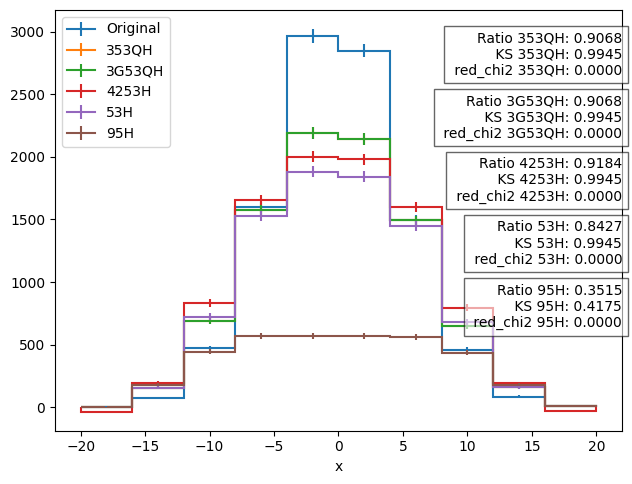

In [ ]:
print_mult_dif(data, ['353QH','3G53QH', '4253H', '53H', '95H'], bin)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, List

def plot_grid_with_smoothing(data_list, binnings, algorithms, figsize=(5, 4)):
    N = len(data_list)
    M = len(binnings)

    fig, axs = plt.subplots(N, M, figsize=(figsize[0]*M, figsize[1]*N*1.5),)

    if N == 1: axs = np.expand_dims(axs, 0)
    if M == 1: axs = np.expand_dims(axs, 1)

    for i, data in enumerate(data_list):
        for j, bin_cfg in enumerate(binnings):
            ax_main = axs[i][j]
            #ax_ratio = axs[i][j+1]
            bins_number, s, e = bin_cfg
            h = hist.Hist(hist.axis.Regular(bins_number, s, e)).fill(data)
            bin_counts = h.counts()
            h.plot(ax=ax_main, label='Original')

            for algo_fn in algorithms:

                mod_data = Smoothing(bin_counts, algo_fn, twice=1)

                h2 = hist.Hist(hist.axis.Regular(bins_number, s, e))
                h2[...] = mod_data
                h2.plot(ax=ax_main, label=algo_fn)
                #ratio = np.divide(y_smooth, y_orig, out=np.ones_like(y_orig), where=y_orig!=0)
                #ax_ratio.step(x, ratio, where='mid', label=name)
                #main_ax_artists, sublot_ax_arists = h.plot_ratio(h2)
            ax_main.set_title(f"Dist {i+1}, Bin {bins_number}")
            #ax_ratio.axhline(1.0, color='gray', linestyle='--', linewidth=0.8)
            #ax_ratio.set_ylim(0.5, 1.5)
            #ax_ratio.set_ylabel("Ratio")
            ax_main.legend(fontsize=8)

    plt.tight_layout()
    plt.show()


In [ ]:
data1 = np.random.normal(loc=mean, scale=std_dev, size=size)
tree = uproot.open(skhep_testdata.data_path("uproot-Zmumu.root"))["events"]
data2 = tree["M"].array()

/usr/local/lib/python3.11/dist-packages/mplhep/utils.py:649: RuntimeWarning: invalid value encountered in sqrt
  return values - np.sqrt(variances), values + np.sqrt(variances)
/usr/local/lib/python3.11/dist-packages/mplhep/utils.py:649: RuntimeWarning: invalid value encountered in sqrt
  return values - np.sqrt(variances), values + np.sqrt(variances)
/usr/local/lib/python3.11/dist-packages/mplhep/utils.py:649: RuntimeWarning: invalid value encountered in sqrt
  return values - np.sqrt(variances), values + np.sqrt(variances)
/usr/local/lib/python3.11/dist-packages/mplhep/utils.py:649: RuntimeWarning: invalid value encountered in sqrt
  return values - np.sqrt(variances), values + np.sqrt(variances)


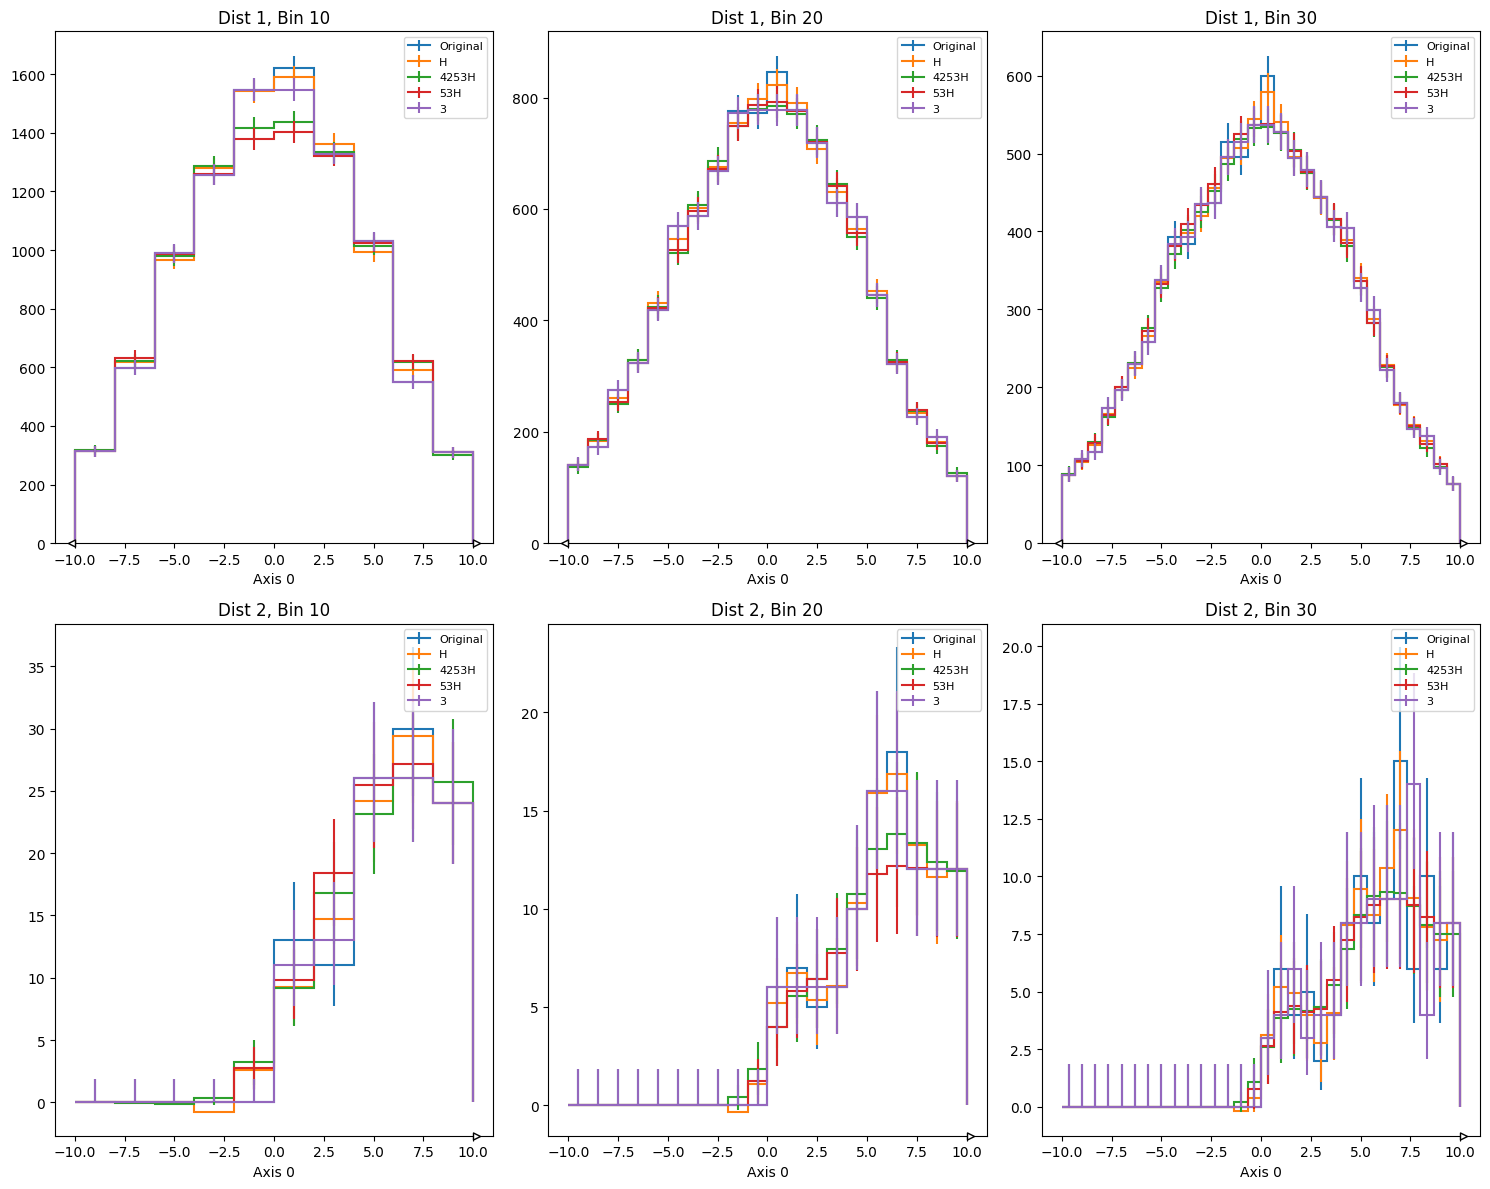

In [ ]:
plot_grid_with_smoothing(
    data_list=[data1, data2],
    binnings=[(10, -10, 10), (20, -10, 10), (30, -10, 10)],
    algorithms=["H", "4253H", "53H", "3"],
)

# WIP smoothRebin

In [ ]:
np.random.seed(42)
data = np.random.normal(3.5, 2.5, size=1_000)
bins = (100, -25, 25)
h = hist.Hist(hist.axis.Regular(bins[0], bins[1], bins[2]))
h.fill(data)

Hist(Regular(100, -25, 25, label='Axis 0'), storage=Double()) # Sum: 1000.0

In [ ]:
values = h.values()
variances = h.variances()
uncertainty = np.sqrt(variances)

total_yield = np.sum(values)
total_uncertainty = np.sqrt(np.sum(variances))
relative_uncertainty = total_uncertainty / total_yield

if relative_uncertainty > 0.05:
    edges = h.axes[0].edges
    h = hist.Hist(hist.axis.Regular(1, edges[0], edges[-1]))
    h[...] = total_yield
else:
    pass

In [ ]:

np.sqrt(h.variances()[np.nonzero(h.variances())])/h.values()[np.nonzero(h.values())]

array([1.        , 0.19611614, 0.05555556, 0.05163978, 0.06041221])

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view

In [ ]:
def find_extrema(h):
    i = 1
    return (h[i] > h[i-1] and h[i] > h[i+1]) or (h[i] < h[i-1] and h[i] < h[i+1])
    #return h[0] != h[1] != h[2]

In [ ]:
def find_chi(h):
    i = 1
    h_neigh = (h[i-1] + h[i+1]) / 2
    return (h[i] - h_neigh) ** 2

In [ ]:
while True:

    arr = sliding_window_view(h.values(), 3)
    var = sliding_window_view(h.variances(), 3)

    result = np.apply_along_axis(find_extrema, axis=1, arr=arr)

    if sum(i for i in result if i == True) <= 2:
        print(3)
        break
    result_chi2 = np.apply_along_axis(find_chi, axis=1, arr=arr) / var[:, 1]
    mask = (result_chi2 != 0) & (~np.isnan(result_chi2))
    min_value = np.min(result_chi2[mask])
    min_index = int(np.flatnonzero(result_chi2 == min_value)[0]) # weird error
    ##print(h.values(), result)
    first_part = h[:min_index].values()
    new_core = np.array(sum(h[min_index:min_index+3].values()))
    last_part = h[min_index+3:].values()
    bins = len(h.values()) - 2
    edges = h.axes[0].edges
    h = hist.Hist(hist.axis.Regular(bins, edges[0], edges[-1]))
    h[...] = np.hstack([first_part, new_core, last_part])

3


/tmp/ipython-input-48-3159979970.py:11: RuntimeWarning: divide by zero encountered in divide
  result_chi2 = np.apply_along_axis(find_chi, axis=1, arr=arr) / var[:, 1]
/tmp/ipython-input-48-3159979970.py:11: RuntimeWarning: invalid value encountered in divide
  result_chi2 = np.apply_along_axis(find_chi, axis=1, arr=arr) / var[:, 1]
